<a href="https://colab.research.google.com/github/eepynool18/FLW_Model_Comparison/blob/main/FLW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Setting up Files
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

flw_data = pd.read_csv("FLWData.csv")
flw_data.shape
flw_data.head()
np.sum(flw_data.isnull())
flw_data2 = flw_data.dropna(subset = ["food_supply_stage"])
np.sum(flw_data2.isnull())


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


,0
m49_code,0
country,0
region,20817
cpc_code,0
commodity,0
year,0
loss_percentage,0
loss_percentage_original,0
loss_quantity,21489
activity,2762


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Define features and target variable
X = flw_data2[['country', 'commodity', 'food_supply_stage']]
y = flw_data2['loss_percentage']

# One-Hot Encoding categorical features
# handle_unknown='ignore' will ignore unknown categories during transform.
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['country', 'commodity', 'food_supply_stage'])
    ],
    remainder='passthrough'  # To keep the 'year' column as is
)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [ ]:
#NearestNeighbors
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

# Create a pipeline that first transforms the data and then fits the KNN model
nnpipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('regressor', neighbors.KNeighborsRegressor(n_neighbors=15, p=1, weights='distance'))
])

nnpipeline.fit(X_train, y_train)
# Predict on the test set with the best model
y_test_pred = nnpipeline.predict(X_test)
print("Test MSE =", mean_squared_error(y_test, y_test_pred))
print("Test R² =", r2_score(y_test, y_test_pred))

# Predict on the training set with the best model
y_train_pred = nnpipeline.predict(X_train)
print("Training MSE =", mean_squared_error(y_train, y_train_pred))
print("Training R² =", r2_score(y_train, y_train_pred))

print("Delta R² =", r2_score(y_test, y_test_pred) - r2_score(y_train, y_train_pred))
print("Delta MSE =", mean_squared_error(y_test, y_test_pred) - mean_squared_error(y_train, y_train_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Test MSE = 18.038034342444824
Test R² = 0.551226503628002
Training MSE = 6.875209101158276
Training R² = 0.8126632173385115
Delta R² = -0.2614367137105096
Delta MSE = 11.162825241286548


In [ ]:
#Neural Network
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Create a pipeline with modified hyperparameters
neural_pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('regressor', MLPRegressor(
        activation='relu',             # Activation function
        alpha=0.01,                    # Increased regularization
        hidden_layer_sizes=(100, 50),   # Reduced complexity (2 layers)
        learning_rate='adaptive',      # Learning rate schedule
        solver='adam',                 # Solver for weight optimization
        random_state=1,                # Fixed random state for reproducibility
        max_iter=1000,                 # Increased iterations
        early_stopping=True,           # Enable early stopping
        validation_fraction=0.1,       # Use 10% of training data for validation
        n_iter_no_change=10            # Stop if no improvement in 10 iterations
    ))
])

# Train the model
neural_pipeline.fit(X_train, y_train)

# Predict and evaluate the model on the test set
y_test_pred = neural_pipeline.predict(X_test)
print("Test MSE =", mean_squared_error(y_test, y_test_pred))
print("Test R² =", r2_score(y_test, y_test_pred))

# Predict and evaluate the model on the training set
y_train_pred = neural_pipeline.predict(X_train)
print("Training MSE =", mean_squared_error(y_train, y_train_pred))
print("Training R² =", r2_score(y_train, y_train_pred))

print("Delta R² =", r2_score(y_test, y_test_pred) - r2_score(y_train, y_train_pred))
print("Delta MSE =", mean_squared_error(y_test, y_test_pred) - mean_squared_error(y_train, y_train_pred))


Test MSE = 14.812419968900553
Test R² = 0.6314775006536033
Training MSE = 10.866016041888123
Training R² = 0.7039210799723167
Delta R² = -0.07244357931871337
Delta MSE = 3.9464039270124296


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
#Tensor Flow
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
import tensorflow as tf # Import tensorflow here

# Define features and target variable
X = flw_data2[['country', 'commodity', 'food_supply_stage', ]]
y = flw_data2['loss_percentage']

# One-Hot Encoding categorical features
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['country', 'commodity', 'food_supply_stage'])
    ],
    remainder='passthrough'  # To keep the 'year' column as is
)

# Preprocess the features
X_encoded = column_transformer.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.20, random_state=42
)

# Build the Keras model
model = Sequential()
model.add(Dense(50, activation='linear', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)))
model.add(LeakyReLU(alpha=0.1))  # Adding Leaky ReLU activation
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, validation_split=0.1, epochs=1000, batch_size=32, verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

# Predict and evaluate the model on the test set
y_test_pred = model.predict(X_test)
print("Test MSE =", mean_squared_error(y_test, y_test_pred))
print("Test R² =", r2_score(y_test, y_test_pred))

# Predict and evaluate the model on the training set
y_train_pred = model.predict(X_train)
print("Training MSE =", mean_squared_error(y_train, y_train_pred))
print("Training R² =", r2_score(y_train, y_train_pred))

print("Delta R² =", r2_score(y_test, y_test_pred) - r2_score(y_train, y_train_pred))
print("Delta MSE =", mean_squared_error(y_test, y_test_pred) - mean_squared_error(y_train, y_train_pred))


Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


496/496 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 41.7497 - val_loss: 31.9816
Epoch 2/1000
496/496 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 26.8995 - val_loss: 29.4805
Epoch 3/1000
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 23.0498 - val_loss: 28.0421
Epoch 4/1000
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22.4317 - val_loss: 26.8895
Epoch 5/1000
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 19.4955 - val_loss: 26.0955
Epoch 6/1000
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20.8208 - val_loss: 25.5751
Epoch 7/1000
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 19.2116 - val_loss: 24.7795
Epoch 8/1000
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 18.6285 - val_loss: 24.4219
Epoch 9/1000
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17.6087 - val_loss: 23.7475
Epoch 10/1000
496/496 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 19.0145 - val_loss: 23.3620
Epoch 11/1000
496/496 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 17.9459 - val_loss: 23.1715
Epoch 12/1000
496/496

In [ ]:
#PolyRidge
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import uniform
from sklearn.metrics import mean_squared_error, r2_score

# Updated best parameters for polynomial regression with Ridge
best_params = {
    'regressor__fit_intercept': False,  # Disable intercept fitting
    'regressor__alpha': 10,             # Regularization strength
    'poly__degree': 3                   # Polynomial degree
}

# Create the updated pipeline using PolynomialFeatures and Ridge with the best parameters
pridge_pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),                 # Preprocessing step
    ('poly', PolynomialFeatures(degree=best_params['poly__degree'], include_bias=False)),  # Polynomial features
    ('regressor', Ridge(alpha=best_params['regressor__alpha'], fit_intercept=best_params['regressor__fit_intercept']))  # Ridge regression
])

# Train the model with the best parameters
pridge_pipeline.fit(X_train, y_train)

# Predict and evaluate the model on the test set
y_test_pred = pridge_pipeline.predict(X_test)
print("Test MSE =", mean_squared_error(y_test, y_test_pred))
print("Test R² =", r2_score(y_test, y_test_pred))

# Predict and evaluate the model on the training set
y_train_pred = pridge_pipeline.predict(X_train)
print("Training MSE =", mean_squared_error(y_train, y_train_pred))
print("Training R² =", r2_score(y_train, y_train_pred))

# Calculate the difference between train and test scores
print("Delta R² =", r2_score(y_test, y_test_pred) - r2_score(y_train, y_train_pred))
print("Delta MSE =", mean_squared_error(y_test, y_test_pred) - mean_squared_error(y_train, y_train_pred))


Test MSE = 14.824886804225663
Test R² = 0.6311673346359914
Training MSE = 9.215683772955781
Training R² = 0.7488895940982555
Delta R² = -0.11772225946226411
Delta MSE = 5.609203031269882


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
#SVM
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Create the pipeline with the updated best parameters
svmpipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),  # Assuming column_transformer is already defined
    ('regressor', svm.SVR(
        kernel='poly',  # Polynomial kernel
        gamma='scale',  # Kernel coefficient
        degree=2,       # Degree of the polynomial kernel
        C=10            # Regularization parameter
    ))
])

# Fit the model with the best parameters
svmpipeline.fit(X_train, y_train)

# Predict and evaluate the model on the test set
y_test_pred = svmpipeline.predict(X_test)
print("Test R² =", r2_score(y_test, y_test_pred))
print("Test MSE =", mean_squared_error(y_test, y_test_pred))

# Predict and evaluate the model on the training set
y_train_pred = svmpipeline.predict(X_train)
print("Training R² =", r2_score(y_train, y_train_pred))
print("Training MSE =", mean_squared_error(y_train, y_train_pred))

# Calculate the difference between train and test scores
print("Delta R² =", r2_score(y_test, y_test_pred) - r2_score(y_train, y_train_pred))
print("Delta MSE =", mean_squared_error(y_test, y_test_pred) - mean_squared_error(y_train, y_train_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Test R² = 0.5887773936254727
Test MSE = 16.528711156384215
Training R² = 0.6592727800288327
Training MSE = 12.504596537195146
Delta R² = -0.07049538640336006
Delta MSE = 4.024114619189069


In [ ]:
#Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV


# Define the linear regression model within a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('regressor', LinearRegression(fit_intercept=True))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__fit_intercept': [True, False],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Output the best parameters
print("Best Parameters:", grid_search.best_params_)

# Use the best model from GridSearchCV to make predictions and evaluate
best_pipeline = grid_search.best_estimator_

# Predict and evaluate the model on the test set
y_test_pred = best_pipeline.predict(X_test)
print("Test MSE =", mean_squared_error(y_test, y_test_pred))
print("Test R² =", r2_score(y_test, y_test_pred))

# Predict and evaluate the model on the training set
y_train_pred = best_pipeline.predict(X_train)
print("Training MSE =", mean_squared_error(y_train, y_train_pred))
print("Training R² =", r2_score(y_train, y_train_pred))

print("Delta R² =", r2_score(y_test, y_test_pred) - r2_score(y_train, y_train_pred))
print("Delta MSE =", mean_squared_error(y_test, y_test_pred) - mean_squared_error(y_train, y_train_pred))



Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'regressor__fit_intercept': True}
Test MSE = 20.096980695274482
Test R² = 0.500001379201473
Training MSE = 17.540899768300747
Training R² = 0.5220427947380535
Delta R² = -0.022041415536580455
Delta MSE = 2.556080926973735


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Define features and target variable
X = flw_data2[['country', 'commodity', 'year', 'food_supply_stage']]
y = flw_data2['loss_percentage']

# One-Hot Encoding categorical features
# handle_unknown='ignore' will ignore unknown categories during transform.
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['country', 'commodity', 'food_supply_stage'])
    ],
    remainder='passthrough'  # To keep the 'year' column as is
)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [ ]:
#Decision Tree
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
# Train the model with the best parameters
dtpipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('regressor', DecisionTreeRegressor(
        criterion='friedman_mse',        # Best criterion
        max_depth=None,                  # No maximum depth
        min_samples_split=15,            # Best min_samples_split
        min_samples_leaf=2,              # Best min_samples_leaf
        ccp_alpha=0.0,                   # Best pruning parameter
        random_state=0                   # Fixed random state for reproducibility
    ))
])
dtpipeline.fit(X_train, y_train)

# Predict and evaluate the model on the test set
y_test_pred = dtpipeline.predict(X_test)
print("Test MSE =", mean_squared_error(y_test, y_test_pred))
print("Test R² =", r2_score(y_test, y_test_pred))

# Predict and evaluate the model on the training set
y_train_pred = dtpipeline.predict(X_train)
print("Training MSE =", mean_squared_error(y_train, y_train_pred))
print("Training R² =", r2_score(y_train, y_train_pred))

print("Delta R² =", r2_score(y_test, y_test_pred) - r2_score(y_train, y_train_pred))
print("Delta MSE =", mean_squared_error(y_test, y_test_pred) - mean_squared_error(y_train, y_train_pred))

Test MSE = 15.360574702916029
Test R² = 0.6178397997895941
Training MSE = 9.039641450843067
Training R² = 0.7536864230748894
Delta R² = -0.1358466232852953
Delta MSE = 6.320933252072962


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Create a pipeline that first transforms the data and then fits the Random Forest model with the best parameters
rfpipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('regressor', RandomForestRegressor(
        n_estimators=157,              # Number of trees in the forest
        max_depth=None,                # No maximum depth
        min_samples_split=9,           # Minimum number of samples required to split an internal node
        min_samples_leaf=2,            # Minimum number of samples required to be at a leaf node
        max_features='sqrt',           # Number of features to consider when looking for the best split
        bootstrap=False,               # Whether bootstrap samples are used when building trees
        random_state=0                 # Fixed random state for reproducibility
    ))
])

# Train the model
rfpipeline.fit(X_train, y_train)

# Predict and evaluate the model on the test set
y_test_pred = rfpipeline.predict(X_test)
print("Test MSE =", mean_squared_error(y_test, y_test_pred))
print("Test R² =", r2_score(y_test, y_test_pred))

# Predict and evaluate the model on the training set
y_train_pred = rfpipeline.predict(X_train)
print("Training MSE =", mean_squared_error(y_train, y_train_pred))
print("Training R² =", r2_score(y_train, y_train_pred))

print("Delta R² =", r2_score(y_test, y_test_pred) - r2_score(y_train, y_train_pred))
print("Delta MSE =", mean_squared_error(y_test, y_test_pred) - mean_squared_error(y_train, y_train_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Test MSE = 16.411150585701385
Test R² = 0.5917022172142978
Training MSE = 11.492068543901626
Training R² = 0.6868623025913312
Delta R² = -0.09516008537703335
Delta MSE = 4.91908204179976


In [ ]:
#Ridge Regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Best parameter found from previous tuning
best_params = {'regressor__alpha': 1.0}

# Create a pipeline with Ridge regression (no polynomial features) using the best alpha parameter
pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),  # Assuming your column transformer handles data preprocessing
    ('regressor', Ridge(alpha=best_params['regressor__alpha']))  # Ridge regression with best alpha
])

# Fit the pipeline with the best parameters
pipeline.fit(X_train, y_train)

# Predict and evaluate the model on the test set
y_test_pred = pipeline.predict(X_test)
print("Test MSE =", mean_squared_error(y_test, y_test_pred))
print("Test R² =", r2_score(y_test, y_test_pred))

# Predict and evaluate the model on the training set
y_train_pred = pipeline.predict(X_train)
print("Training MSE =", mean_squared_error(y_train, y_train_pred))
print("Training R² =", r2_score(y_train, y_train_pred))

# Calculate the difference between train and test scores
print("Delta R² =", r2_score(y_test, y_test_pred) - r2_score(y_train, y_train_pred))
print("Delta MSE =", mean_squared_error(y_test, y_test_pred) - mean_squared_error(y_train, y_train_pred))


Test MSE = 20.364077592564602
Test R² = 0.4933561979033675
Training MSE = 17.663236270779986
Training R² = 0.5187093504108607
Delta R² = -0.02535315250749326
Delta MSE = 2.7008413217846154


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


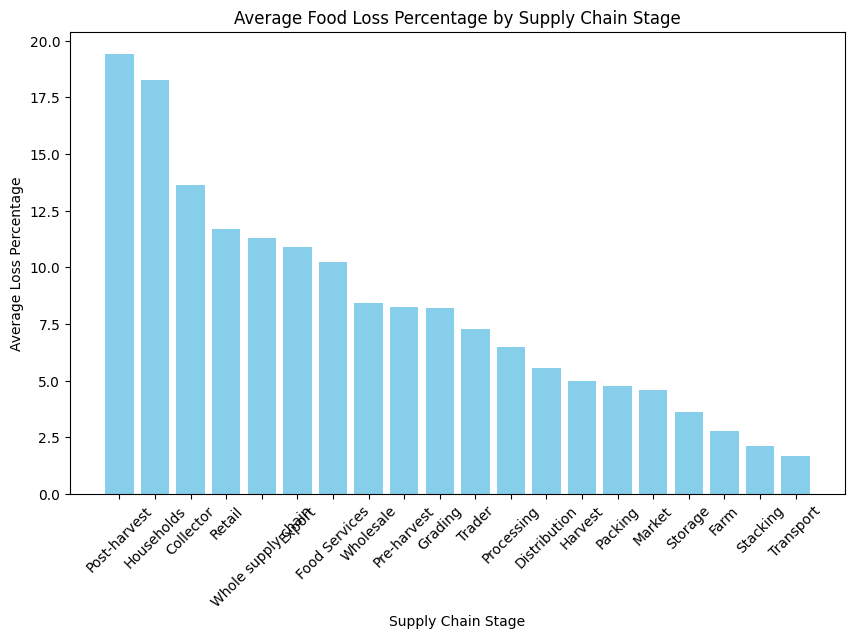

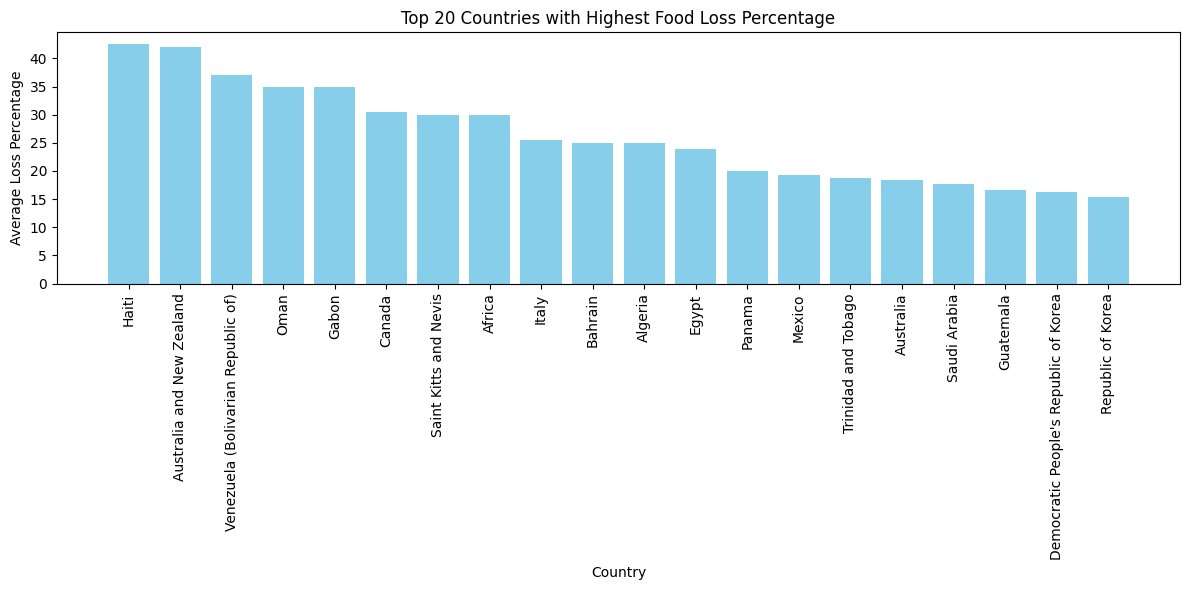

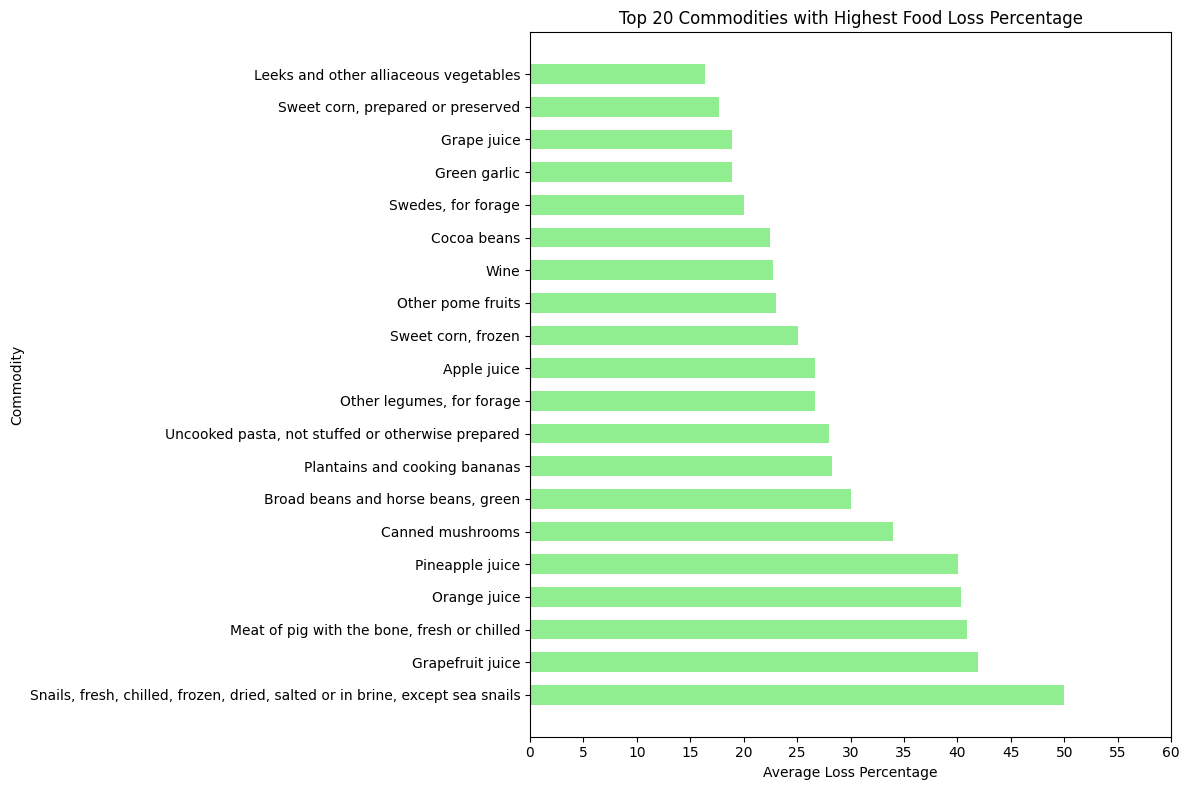

In [ ]:
#Raw Data Visualizations
import pandas as pd
import matplotlib.pyplot as plt

# Group the raw data by 'food_supply_stage' and calculate the mean loss percentage for each stage
stage_avg_loss = flw_data2.groupby('food_supply_stage')['loss_percentage'].mean().reset_index()

# Sort the stages by loss percentage for better visualization
stage_avg_loss = stage_avg_loss.sort_values(by='loss_percentage', ascending=False)

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(stage_avg_loss['food_supply_stage'], stage_avg_loss['loss_percentage'], color='skyblue')
plt.title('Average Food Loss Percentage by Supply Chain Stage')
plt.xlabel('Supply Chain Stage')
plt.ylabel('Average Loss Percentage')
plt.xticks(rotation=45)
plt.show()


# Group by 'country' and calculate the average loss percentage, then sort and select the top 20
top_countries = flw_data2.groupby('country')['loss_percentage'].mean().reset_index()
top_countries = top_countries.sort_values(by='loss_percentage', ascending=False).head(20)

# Group by 'commodity' and calculate the average loss percentage, then sort and select the top 20
top_commodities = flw_data2.groupby('commodity')['loss_percentage'].mean().reset_index()
top_commodities = top_commodities.sort_values(by='loss_percentage', ascending=False).head(20)

# Plot for top countries
plt.figure(figsize=(12, 6))
plt.bar(top_countries['country'], top_countries['loss_percentage'], color='skyblue')
plt.title('Top 20 Countries with Highest Food Loss Percentage')
plt.xlabel('Country')
plt.ylabel('Average Loss Percentage')
plt.xticks(rotation=90)
plt.tight_layout()  # Ensures proper formatting of x-ticks
plt.show()

# Plot for top commodities as a horizontal bar chart
plt.figure(figsize=(12, 8))  # Increase the figure size to make the graph larger
plt.barh(top_commodities['commodity'], top_commodities['loss_percentage'], color='lightgreen', height=0.6)  # Adjust bar height

plt.title('Top 20 Commodities with Highest Food Loss Percentage')
plt.xlabel('Average Loss Percentage')
plt.ylabel('Commodity')

# Add padding to the x-axis
plt.xlim(0, top_commodities['loss_percentage'].max() + 10)
plt.xticks(range(0, int(top_commodities['loss_percentage'].max()) + 15, 5))

plt.tight_layout()  # Ensures everything fits in the figure
plt.show()



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Define features and target variable
X = flw_data2[['country', 'commodity', 'food_supply_stage']]
y = flw_data2['loss_percentage']

# One-Hot Encoding categorical features
# handle_unknown='ignore' will ignore unknown categories during transform.
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['country', 'commodity', 'food_supply_stage'])
    ],
    remainder='passthrough'  # To keep the 'year' column as is
)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [ ]:
#Neural Network Test

# Function to predict food loss percentage based on user input
def predict_food_loss(commodity, country, food_supply_stage, model):
    # Create a DataFrame from user inputs
    input_data = pd.DataFrame({
        'commodity': [commodity],
        'country': [country],
        'food_supply_stage': [food_supply_stage]
    })

    # Predict the loss percentage using the trained neural network model
    predicted_loss_percentage = model.predict(input_data)  # Changed line

    # Display the prediction
    print(f"Predicted food loss percentage for commodity '{commodity}', country '{country}', "
          f"and supply stage '{food_supply_stage}': {predicted_loss_percentage[0]:.2f}%")

# Example usage
predict_food_loss('Rice', 'China', 'Storage', neural_pipeline)



Predicted food loss percentage for commodity 'Rice', country 'China', and supply stage 'Storage': 1.90%


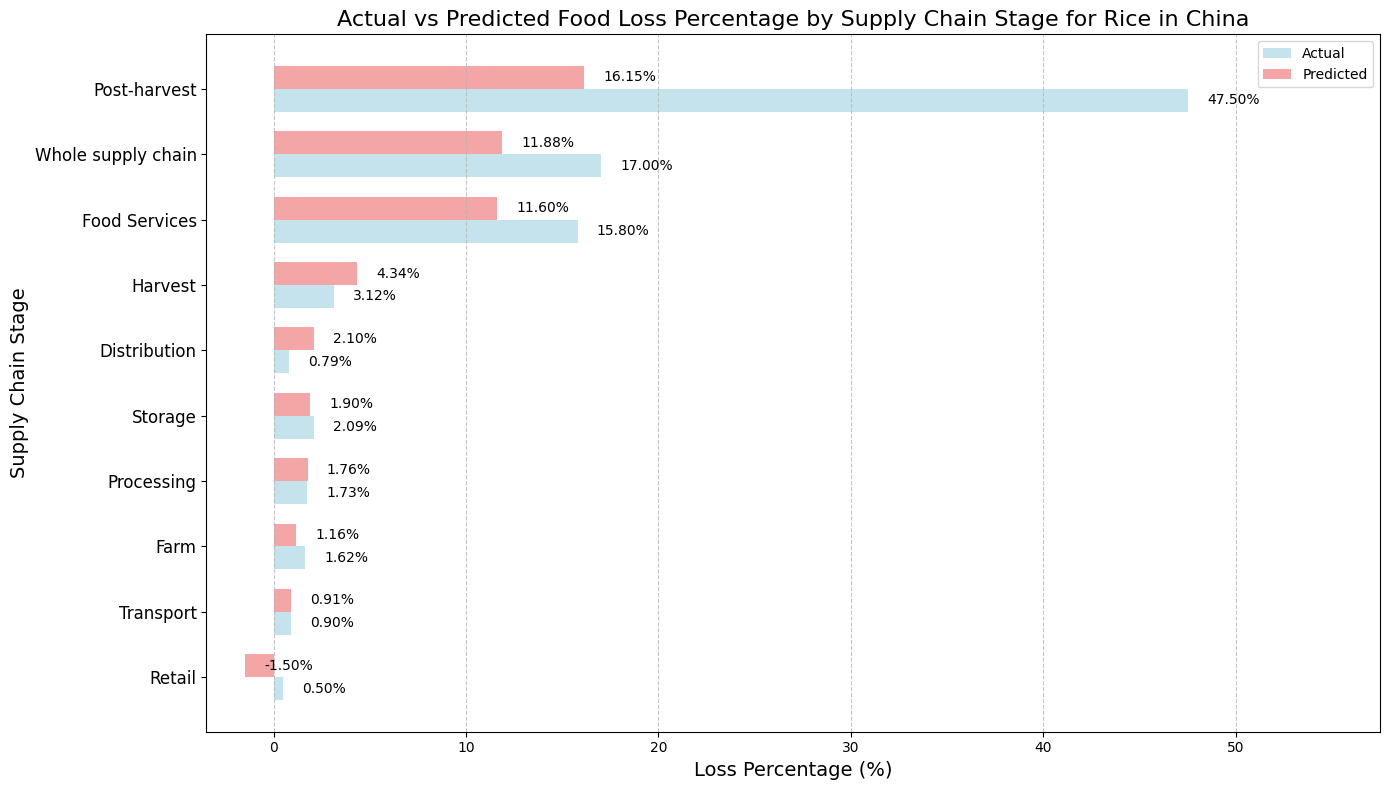

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to predict and visualize food loss for each stage of the supply chain
def visualize_food_loss_by_stage_nn(commodity, country, model, data):
    # Filter the data to find relevant stages for the given commodity and country
    relevant_data = data[(data['commodity'] == commodity) & (data['country'] == country)]

    # Check if there are any relevant entries
    if relevant_data.empty:
        print(f"No data found for commodity '{commodity}' in country '{country}'.")
        return

    # Get the unique supply stages available for this commodity and country
    stages = relevant_data['food_supply_stage'].unique()

    # Create lists to store actual and predicted loss percentages
    actual_values = []
    predicted_values = []

    # Iterate over each supply stage
    for stage in stages:
        # Get the actual average loss percentage from the dataset (if available)
        avg_actual_loss = relevant_data[relevant_data['food_supply_stage'] == stage]['loss_percentage'].mean()
        actual_values.append(avg_actual_loss)

        # Create input data for the model (without 'year')
        input_data = pd.DataFrame({
            'commodity': [commodity],
            'country': [country],
            'food_supply_stage': [stage]
        })

        # Predict the loss percentage using the neural network model
        predicted_loss_percentage = model.predict(input_data)[0]
        predicted_values.append(predicted_loss_percentage)

    # Create a DataFrame from the results
    results_df = pd.DataFrame({
        'food_supply_stage': stages,
        'actual_loss_percentage': actual_values,
        'predicted_loss_percentage': predicted_values
    })

    # Sort the DataFrame by predicted loss percentage
    results_df.sort_values(by='predicted_loss_percentage', ascending=True, inplace=True)

    # Plot the results
    plt.figure(figsize=(14, 8))  # Increase figure size for better visibility

    bar_width = 0.35  # Width of the bars
    x = range(len(stages))  # X positions for the bars

    # Plot actual values
    actual_bars = plt.barh(x, results_df['actual_loss_percentage'], height=bar_width,
                           color='lightblue', label='Actual', alpha=0.7)

    # Plot predicted values
    predicted_bars = plt.barh([i + bar_width for i in x], results_df['predicted_loss_percentage'],
                              height=bar_width, color='lightcoral', label='Predicted', alpha=0.7)

    # Customize the plot
    plt.title(f'Actual vs Predicted Food Loss Percentage by Supply Chain Stage for {commodity} in {country}', fontsize=16)
    plt.xlabel('Loss Percentage (%)', fontsize=14)
    plt.ylabel('Supply Chain Stage', fontsize=14)
    plt.yticks([i + bar_width / 2 for i in x], results_df['food_supply_stage'], fontsize=12)

    # Set x-axis limits based on the data with padding
    min_val = min(min(results_df['actual_loss_percentage']), min(results_df['predicted_loss_percentage']))
    max_val = max(max(results_df['actual_loss_percentage']), max(results_df['predicted_loss_percentage']))
    plt.xlim(min_val - 2, max_val + 10)  # Adding padding of 5% for better visualization

    # Helper function to add labels to bars
    def add_labels(bars, values):
        """Add labels to bars."""
        for bar, value in zip(bars, values):
            if pd.notna(value):
                plt.text(
                    bar.get_width() + 1,  # Slightly to the right of the bar
                    bar.get_y() + bar.get_height() / 2,  # Centered vertically
                    f'{value:.2f}%',
                    va='center', ha='left', fontsize=10
                )

    # Add labels to both actual and predicted bars
    add_labels(actual_bars, results_df['actual_loss_percentage'])
    add_labels(predicted_bars, results_df['predicted_loss_percentage'])

    # Add gridlines
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
visualize_food_loss_by_stage_nn('Rice', 'China', neural_pipeline, flw_data2)

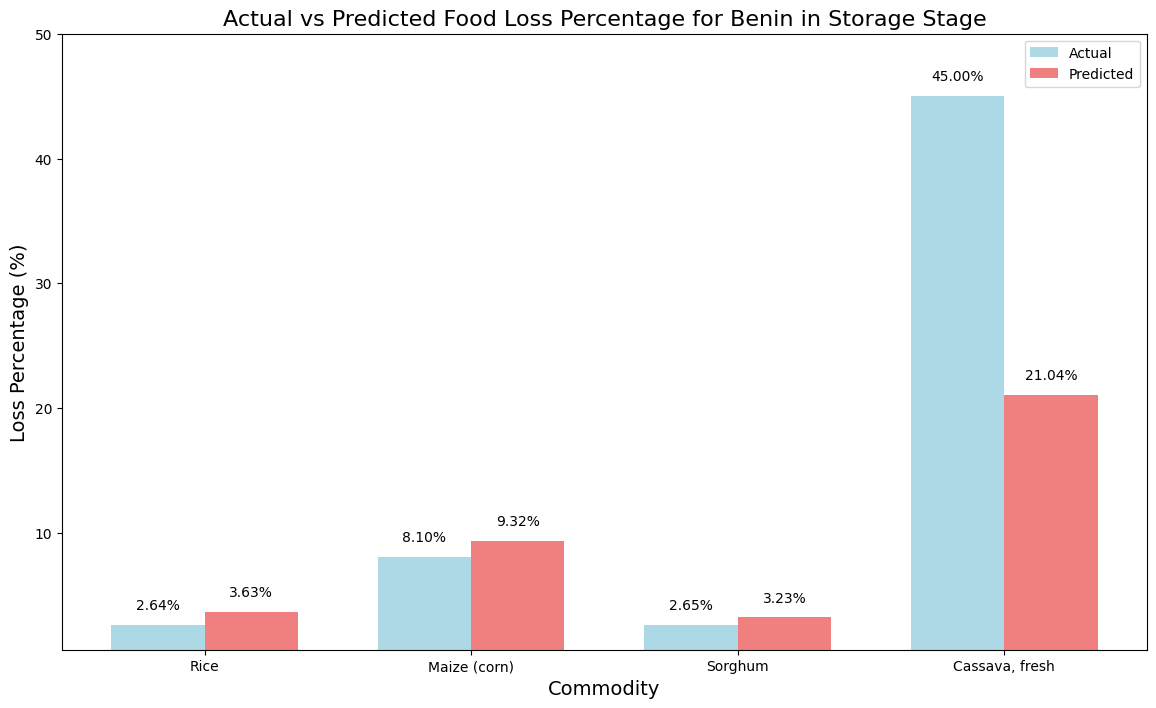

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to compare actual vs predicted food loss percentages by commodity
def visualize_food_loss_comparison(country, food_supply_stage, model, data):
    # Filter the data to find relevant commodities for the given country and supply stage
    relevant_data = data[(data['country'] == country) & (data['food_supply_stage'] == food_supply_stage)]

    # Check if there are any relevant entries
    if relevant_data.empty:
        print(f"No data found for country '{country}' in supply stage '{food_supply_stage}'.")
        return

    # Get the unique commodities available for this country and supply stage
    commodities = relevant_data['commodity'].unique()

    # Create lists to store actual and predicted loss percentages
    actual_values = []
    predicted_values = []

    # Iterate over each commodity
    for commodity in commodities:
        # Get the actual average loss percentage from the data
        avg_actual_loss = relevant_data[relevant_data['commodity'] == commodity]['loss_percentage'].mean()
        actual_values.append(avg_actual_loss)

        # Create input data for the model prediction
        input_data = pd.DataFrame({
            'commodity': [commodity],
            'country': [country],
            'food_supply_stage': [food_supply_stage]
        })

        # Predict the loss percentage using the trained neural network model
        predicted_loss = model.predict(input_data)[0]
        predicted_values.append(predicted_loss)

    # Create a DataFrame from the results for easier plotting
    comparison_df = pd.DataFrame({
        'commodity': commodities,
        'actual_loss_percentage': actual_values,
        'predicted_loss_percentage': predicted_values
    })

    # Plot the actual and predicted values side-by-side for each commodity
    bar_width = 0.35  # Width of the bars

    fig, ax = plt.subplots(figsize=(14, 8))

    # X positions for the bars
    x = np.arange(len(commodities))

    # Plot actual values
    ax.bar(x - bar_width / 2, comparison_df['actual_loss_percentage'],
           bar_width, label='Actual', color='lightblue')

    # Plot predicted values
    ax.bar(x + bar_width / 2, comparison_df['predicted_loss_percentage'],
           bar_width, label='Predicted', color='lightcoral')

    # Customize the plot
    ax.set_title(f'Actual vs Predicted Food Loss Percentage for {country} in {food_supply_stage} Stage', fontsize=16)
    ax.set_xlabel('Commodity', fontsize=14)
    ax.set_ylabel('Loss Percentage (%)', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(commodities)

    # Set y-axis limits based on the data with padding
    min_val = min(min(comparison_df['actual_loss_percentage']), min(comparison_df['predicted_loss_percentage']))
    max_val = max(max(comparison_df['actual_loss_percentage']), max(comparison_df['predicted_loss_percentage']))
    ax.set_ylim(min_val - 2, max_val + 5)  # Adding padding of 5 for better visualization

    ax.legend()

    # Add value labels on top of the bars
    for i in range(len(comparison_df)):
        ax.text(i - bar_width / 2, comparison_df['actual_loss_percentage'][i] + 1,
                f'{comparison_df["actual_loss_percentage"][i]:.2f}%', ha='center', va='bottom', fontsize=10)
        ax.text(i + bar_width / 2, comparison_df['predicted_loss_percentage'][i] + 1,
                f'{comparison_df["predicted_loss_percentage"][i]:.2f}%', ha='center', va='bottom', fontsize=10)

# Example usage
visualize_food_loss_comparison('Benin', 'Storage', neural_pipeline, flw_data2)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Define features and target variable
X = flw_data2[['country', 'commodity', 'year', 'food_supply_stage']]
y = flw_data2['loss_percentage']

# One-Hot Encoding categorical features
# handle_unknown='ignore' will ignore unknown categories during transform.
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['country', 'commodity', 'food_supply_stage'])
    ],
    remainder='passthrough'  # To keep the 'year' column as is
)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [ ]:
#Decision Tree Test
# Function to predict food loss percentage based on user input
def predict_food_loss(commodity, country, food_supply_stage, year, model):
    # Create a DataFrame from user inputs
    input_data = pd.DataFrame({
        'commodity': [commodity],
        'country': [country],
        'food_supply_stage': [food_supply_stage],
        'year': [year]
    })

    # Instead of transforming again, directly use the input_data
    predicted_loss_percentage = model.predict(input_data)

    # Display the prediction
    print(f"Predicted food loss percentage for commodity '{commodity}', country '{country}', "
          f"supply stage '{food_supply_stage}', in the year {year}: {predicted_loss_percentage[0]:.2f}%")

# Example usage
predict_food_loss('Rice', 'Benin', 'Storage', 2024, dtpipeline)

Predicted food loss percentage for commodity 'Rice', country 'Benin', supply stage 'Storage', in the year 2024: 4.21%


Using data from the year 2021.


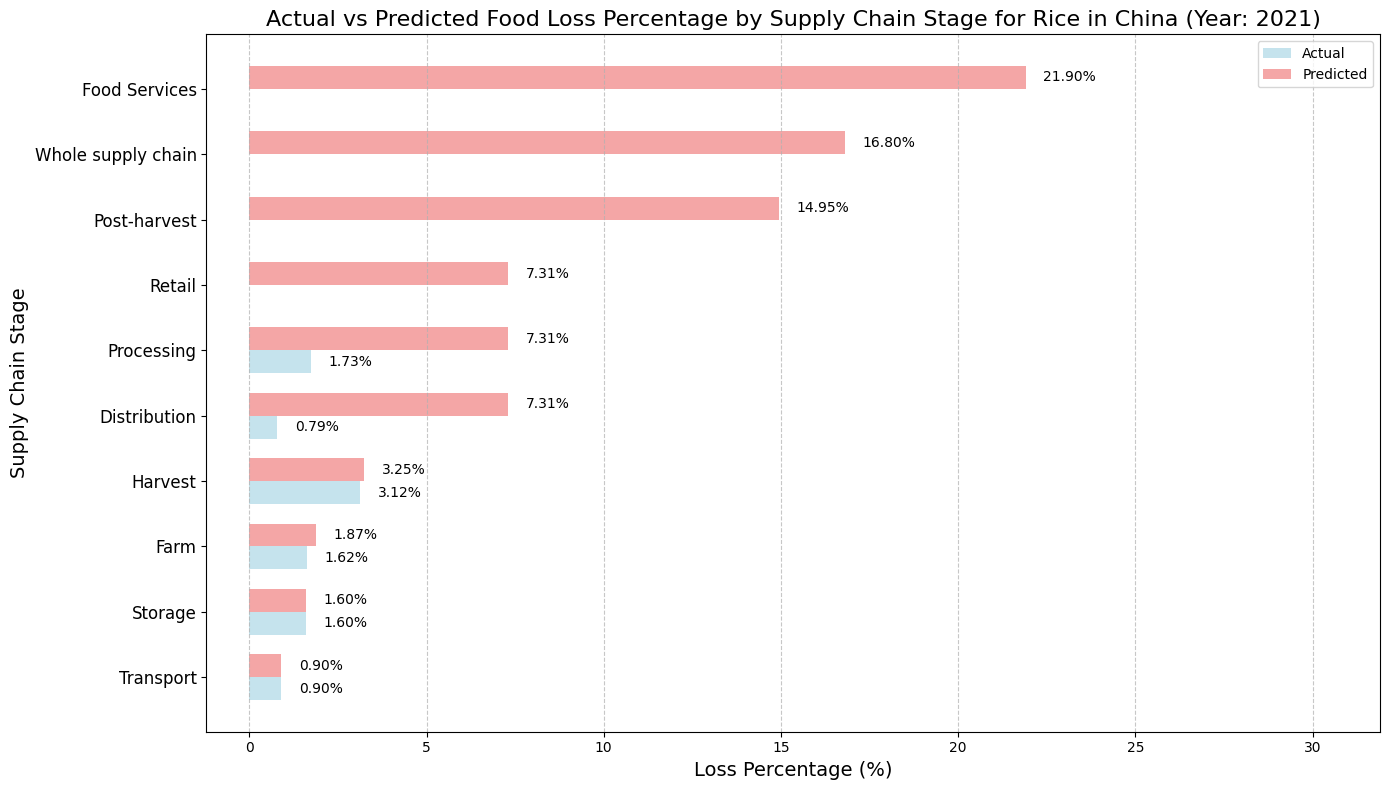

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to predict and visualize food loss for each stage of the supply chain
def visualize_food_loss_by_stage(commodity, country, year, model, data):
    # Filter the data to find relevant stages for the given commodity and country
    relevant_data = data[(data['commodity'] == commodity) & (data['country'] == country)]

    # Check if there are any relevant entries
    if relevant_data.empty:
        print(f"No data found for commodity '{commodity}' in country '{country}'.")
        return

    # Get the unique supply stages available for this commodity and country
    stages = relevant_data['food_supply_stage'].unique()

    # Check if the input year exists in the dataset
    year_exists = year in relevant_data['year'].unique()
    if year_exists:
        relevant_data = relevant_data[relevant_data['year'] == year]
        print(f"Using data from the year {year}.")
    else:
        print(f"Year {year} not found. Predicting food loss for available supply stages.")

    # Create lists to store actual and predicted loss percentages
    actual_values = []
    predicted_values = []

    # Iterate over each supply stage
    for stage in stages:
        # Get the actual average loss percentage if the year exists
        if year_exists:
            avg_actual_loss = relevant_data[relevant_data['food_supply_stage'] == stage]['loss_percentage'].mean()
        else:
            avg_actual_loss = None  # No actual data available

        actual_values.append(avg_actual_loss)

        # Create input data for the current stage (year still passed for prediction)
        input_data = pd.DataFrame({
            'commodity': [commodity],
            'country': [country],
            'food_supply_stage': [stage],
            'year': [year]
        })

        # Predict the loss percentage using the trained decision tree model
        predicted_loss_percentage = model.predict(input_data)[0]
        predicted_values.append(predicted_loss_percentage)

    # Create a DataFrame from the results
    results_df = pd.DataFrame({
        'food_supply_stage': stages,
        'actual_loss_percentage': actual_values,
        'predicted_loss_percentage': predicted_values
    })

    # Sort the DataFrame by predicted loss percentage
    results_df.sort_values(by='predicted_loss_percentage', ascending=True, inplace=True)

    # Plot the results
    plt.figure(figsize=(14, 8))  # Increase figure size for better visibility

    bar_width = 0.35  # Width of the bars
    x = range(len(stages))  # X positions for the bars

    # Plot actual values if available
    if year_exists:
        actual_bars = plt.barh(x, results_df['actual_loss_percentage'], height=bar_width,
                               color='lightblue', label='Actual', alpha=0.7)

    # Plot predicted values
    predicted_bars = plt.barh([i + bar_width for i in x], results_df['predicted_loss_percentage'],
                              height=bar_width, color='lightcoral', label='Predicted', alpha=0.7)

    # Customize the plot
    plt.title(f'Actual vs Predicted Food Loss Percentage by Supply Chain Stage for {commodity} in {country} (Year: {year})', fontsize=16)
    plt.xlabel('Loss Percentage (%)', fontsize=14)
    plt.ylabel('Supply Chain Stage', fontsize=14)
    plt.yticks([i + bar_width / 2 for i in x], results_df['food_supply_stage'], fontsize=12)
    plt.xlim(0, 100)  # Assuming percentages are between 0 and 100

    # Add value labels on bars
    def add_labels(bars, values):
        """Helper function to add labels above bars."""
        for bar, value in zip(bars, values):
            if pd.notna(value):
                plt.text(
                    bar.get_width() + 0.5,  # Position slightly to the right of the bar
                    bar.get_y() + bar.get_height() / 2,  # Center vertically within the bar
                    f'{value:.2f}%',
                    va='center', ha='left', fontsize=10
                )

    # Add labels to both actual and predicted bars
    if year_exists:
        add_labels(actual_bars, results_df['actual_loss_percentage'])
    add_labels(predicted_bars, results_df['predicted_loss_percentage'])
  # Set x-axis limits based on the data with padding
    min_val = min(min(results_df['actual_loss_percentage']), min(results_df['predicted_loss_percentage']))
    max_val = max(max(results_df['actual_loss_percentage']), max(results_df['predicted_loss_percentage']))
    plt.xlim(min_val - 2, max_val + 10)  # Adding padding of 5% for better visualization
    # Add gridlines
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
visualize_food_loss_by_stage('Rice', 'China', 2021, dtpipeline, flw_data2)


Year 2030 not found. Predicting food loss for available commodities.


ValueError: min() arg is an empty sequence

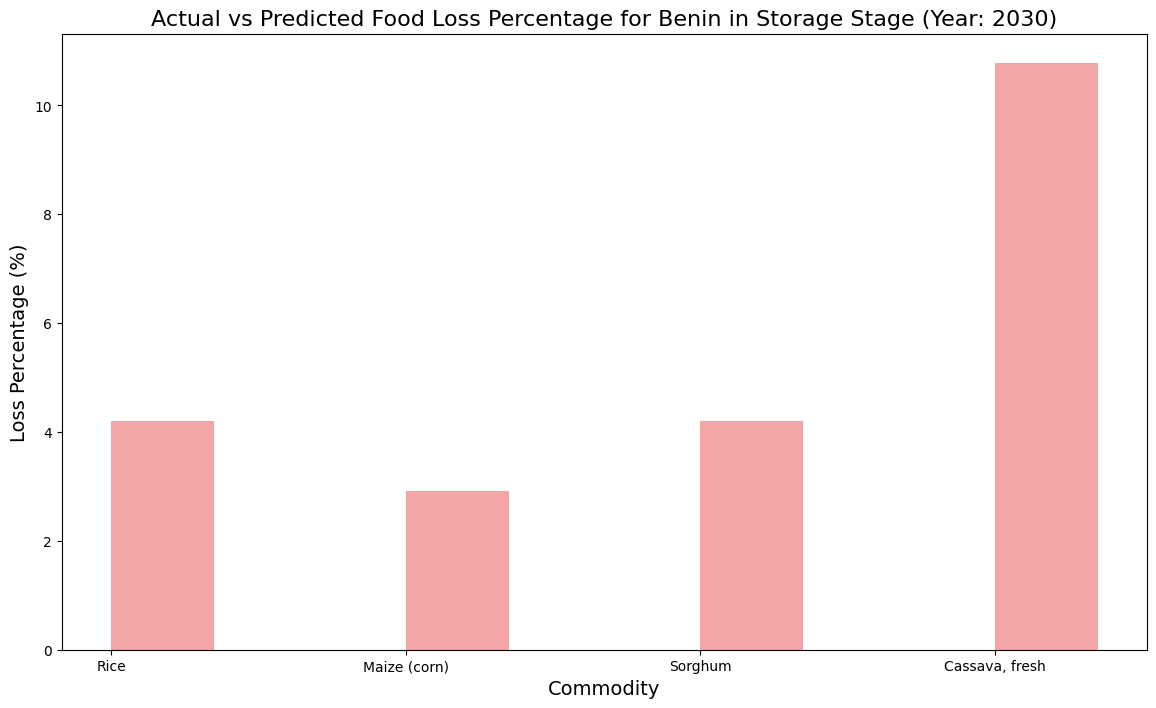

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to compare actual vs predicted food loss percentages by commodity
def visualize_food_loss_comparison(country, food_supply_stage, year, model, data):
    # Filter the data to find relevant commodities for the given country and supply stage
    relevant_data = data[(data['country'] == country) & (data['food_supply_stage'] == food_supply_stage)]

    # Get the unique commodities for this country and supply stage
    commodities = relevant_data['commodity'].unique()

    # Create lists to store actual and predicted loss percentages
    actual_values = []
    predicted_values = []

    # If the requested year exists, filter by it for actual values
    year_exists = year in relevant_data['year'].unique()
    if year_exists:
        relevant_data = relevant_data[relevant_data['year'] == year]
        print(f"Using data from the year {year}.")
    else:
        print(f"Year {year} not found. Predicting food loss for available commodities.")

    # Iterate over each commodity
    for commodity in commodities:
        # Get the actual average loss percentage if available
        if year_exists:
            avg_actual_loss = relevant_data[relevant_data['commodity'] == commodity]['loss_percentage'].mean()
        else:
            avg_actual_loss = np.nan  # No actual data available

        actual_values.append(avg_actual_loss)

        # Create input data for the model prediction (without relying on the year)
        input_data = pd.DataFrame({
            'commodity': [commodity],
            'country': [country],
            'food_supply_stage': [food_supply_stage],
            'year': [year]  # Keep year for prediction, but model handles any input year
        })

        # Predict the loss percentage using the trained model
        predicted_loss = model.predict(input_data)[0]
        predicted_values.append(predicted_loss)

    # Create a DataFrame from the results for easier plotting
    comparison_df = pd.DataFrame({
        'commodity': commodities,
        'actual_loss_percentage': actual_values,
        'predicted_loss_percentage': predicted_values
    })

    # Plot the actual and predicted values side-by-side for each commodity
    bar_width = 0.35  # Width of the bars

    fig, ax = plt.subplots(figsize=(14, 8))

    # X positions for the bars
    x = np.arange(len(commodities))

    # Plot actual values (handle missing values gracefully)
    ax.bar(x - bar_width / 2, comparison_df['actual_loss_percentage'],
           bar_width, label='Actual', color='lightblue', alpha=0.7)

    # Plot predicted values
    ax.bar(x + bar_width / 2, comparison_df['predicted_loss_percentage'],
           bar_width, label='Predicted', color='lightcoral', alpha=0.7)

    # Customize the plot
    ax.set_title(f'Actual vs Predicted Food Loss Percentage for {country} in {food_supply_stage} Stage (Year: {year})', fontsize=16)
    ax.set_xlabel('Commodity', fontsize=14)
    ax.set_ylabel('Loss Percentage (%)', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(commodities)

    # Set y-axis limits based on the data with padding
    min_val = min(min(comparison_df['actual_loss_percentage'].dropna()),
                  min(comparison_df['predicted_loss_percentage'].dropna()))
    max_val = max(max(comparison_df['actual_loss_percentage'].dropna()),
                  max(comparison_df['predicted_loss_percentage'].dropna()))
    ax.set_ylim(min_val -2, max_val + 5)  # Adding padding of 5 for better visualization

    ax.legend()

    # Add value labels on top of the bars
    for i in range(len(comparison_df)):
        # Actual value label (only if it's not NaN)
        if not np.isnan(comparison_df['actual_loss_percentage'][i]):
            ax.text(i - bar_width / 2, comparison_df['actual_loss_percentage'][i] + 1,
                    f'{comparison_df["actual_loss_percentage"][i]:.2f}%', ha='center', va='bottom', fontsize=10)

        # Predicted value label
        ax.text(i + bar_width / 2, comparison_df['predicted_loss_percentage'][i] + 1,
                f'{comparison_df["predicted_loss_percentage"][i]:.2f}%', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

# Example usage
visualize_food_loss_comparison('Benin', 'Storage', 2030, dtpipeline, flw_data2)
